<a href="https://colab.research.google.com/github/Aditri-07/Stock-Price-Prediction/blob/main/Stock_Prediction_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.optimizers import Adam

In [2]:
data = pd.read_csv('GOOG.csv')
data

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,GOOG,2016-06-14 00:00:00+00:00,718.27,722.470,713.1200,716.48,1306065,718.27,722.470,713.1200,716.48,1306065,0.0,1.0
1,GOOG,2016-06-15 00:00:00+00:00,718.92,722.980,717.3100,719.00,1214517,718.92,722.980,717.3100,719.00,1214517,0.0,1.0
2,GOOG,2016-06-16 00:00:00+00:00,710.36,716.650,703.2600,714.91,1982471,710.36,716.650,703.2600,714.91,1982471,0.0,1.0
3,GOOG,2016-06-17 00:00:00+00:00,691.72,708.820,688.4515,708.65,3402357,691.72,708.820,688.4515,708.65,3402357,0.0,1.0
4,GOOG,2016-06-20 00:00:00+00:00,693.71,702.480,693.4100,698.77,2082538,693.71,702.480,693.4100,698.77,2082538,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253,GOOG,2021-06-07 00:00:00+00:00,2466.09,2468.000,2441.0725,2451.32,1192453,2466.09,2468.000,2441.0725,2451.32,1192453,0.0,1.0
1254,GOOG,2021-06-08 00:00:00+00:00,2482.85,2494.495,2468.2400,2479.90,1253253,2482.85,2494.495,2468.2400,2479.90,1253253,0.0,1.0
1255,GOOG,2021-06-09 00:00:00+00:00,2491.40,2505.000,2487.3300,2499.50,1006337,2491.40,2505.000,2487.3300,2499.50,1006337,0.0,1.0
1256,GOOG,2021-06-10 00:00:00+00:00,2521.60,2523.260,2494.0000,2494.01,1561733,2521.60,2523.260,2494.0000,2494.01,1561733,0.0,1.0


In [3]:
data=data[['date','close']] #preprocess data

import datetime
def str_to_datetime(s):
    date_part=s.split(' ')[0]
    split = date_part.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year=year, month=month, day=day)


datetime_object = str_to_datetime('2015-01-01')
datetime_object

data['date']=data['date'].apply(str_to_datetime)

data.index=data.pop('date')
data

<ipython-input-3-8963548f7487>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date']=data['date'].apply(str_to_datetime)


,close
date,
2016-06-14,718.27
2016-06-15,718.92
2016-06-16,710.36
2016-06-17,691.72
2016-06-20,693.71
...,...
2021-06-07,2466.09
2021-06-08,2482.85
2021-06-09,2491.40


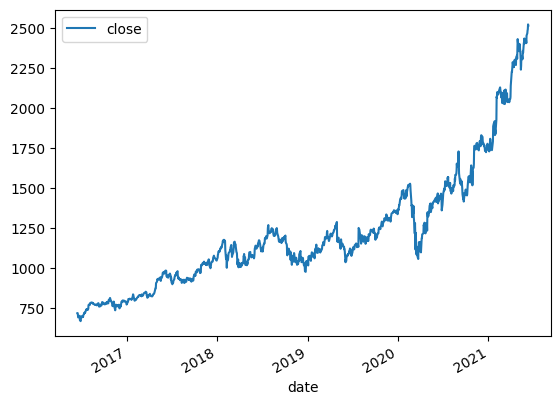

In [4]:
data.plot.line(y='close',use_index=True) #plot the preprocessed data
plt.show()

In [5]:
from copy import deepcopy as dc  #prepare data for lstm
def data_prep_for_lstm(data, n_features):
    data = data.copy()
    for i in range(n_features,0,-1):
        data[f'close(t-{i})'] = data['close'].shift(i)
    data.dropna(inplace=True)
    return data

lookback = 7
lstm_data = data_prep_for_lstm(data, lookback)
lstm_data

,close,close(t-7),close(t-6),close(t-5),close(t-4),close(t-3),close(t-2),close(t-1)
date,,,,,,,,
2016-06-23,701.87,718.27,718.92,710.36,691.72,693.71,695.94,697.46
2016-06-24,675.22,718.92,710.36,691.72,693.71,695.94,697.46,701.87
2016-06-27,668.26,710.36,691.72,693.71,695.94,697.46,701.87,675.22
2016-06-28,680.04,691.72,693.71,695.94,697.46,701.87,675.22,668.26
2016-06-29,684.11,693.71,695.94,697.46,701.87,675.22,668.26,680.04
...,...,...,...,...,...,...,...,...
2021-06-07,2466.09,2433.53,2402.51,2411.56,2429.81,2421.28,2404.61,2451.76
2021-06-08,2482.85,2402.51,2411.56,2429.81,2421.28,2404.61,2451.76,2466.09
2021-06-09,2491.40,2411.56,2429.81,2421.28,2404.61,2451.76,2466.09,2482.85


In [6]:
scaler = MinMaxScaler(feature_range=(0, 1)) #normalize the data
normalized_lstm_data = scaler.fit_transform(lstm_data)

In [7]:
train_size = int(len(normalized_lstm_data) * 0.8) #prepare training and testing tests
test_size = len(normalized_lstm_data) - train_size
train_data, test_data = normalized_lstm_data[:train_size], normalized_lstm_data[train_size:]

In [8]:
X_train = train_data[:, 1:]  #features
y_train = train_data[:, 0]   #target variable
X_test = test_data[:, 1:]
y_test = test_data[:, 0]

In [9]:
X_train = X_train.reshape((X_train.shape[0], lookback, 1)) #reshape the data for lstm
X_test = X_test.reshape((X_test.shape[0], lookback, 1))

In [10]:
y = np.concatenate((y_train, y_test), axis=0)

In [11]:
model = Sequential([
    Input(shape=(lookback, 1)),
    LSTM(64),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
]) #define the lstm model

model.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['mean_absolute_error'])

In [12]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32) #train

Epoch 1/50
32/32 [==============================] - 3s 6ms/step - loss: 0.0148 - mean_absolute_error: 0.0903
Epoch 2/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0013 - mean_absolute_error: 0.0273
Epoch 3/50
32/32 [==============================] - 0s 6ms/step - loss: 2.5682e-04 - mean_absolute_error: 0.0115
Epoch 4/50
32/32 [==============================] - 0s 6ms/step - loss: 2.3538e-04 - mean_absolute_error: 0.0111
Epoch 5/50
32/32 [==============================] - 0s 5ms/step - loss: 2.2533e-04 - mean_absolute_error: 0.0106
Epoch 6/50
32/32 [==============================] - 0s 6ms/step - loss: 2.3526e-04 - mean_absolute_error: 0.0109
Epoch 7/50
32/32 [==============================] - 0s 6ms/step - loss: 2.3851e-04 - mean_absolute_error: 0.0111
Epoch 8/50
32/32 [==============================] - 0s 7ms/step - loss: 2.4668e-04 - mean_absolute_error: 0.0112
Epoch 9/50
32/32 [==============================] - 0s 6ms/step - loss: 2.1992e-04 - mean_absolute_error

In [13]:
y_pred_normalized= model.predict(X_test) #predict

8/8 [==============================] - 1s 4ms/step


In [14]:
scaler_inverse = MinMaxScaler() #inverse the data
scaler_inverse.fit(y.reshape(-1, 1)) #fit scaler on concatenated y data

y_pred = scaler_inverse.inverse_transform(y_pred_normalized).flatten()

In [15]:
rmse = mean_squared_error(y_test, y_pred, squared=False) #evaluate
print("RMSE:", rmse)

RMSE: 0.052954046768490665


In [16]:
#inverse the normalized
y_train_inverse = scaler_inverse.inverse_transform(y_train.reshape(-1, 1)).flatten()
y_test_inverse = scaler_inverse.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_inverse = scaler_inverse.inverse_transform(y_pred_normalized).flatten()

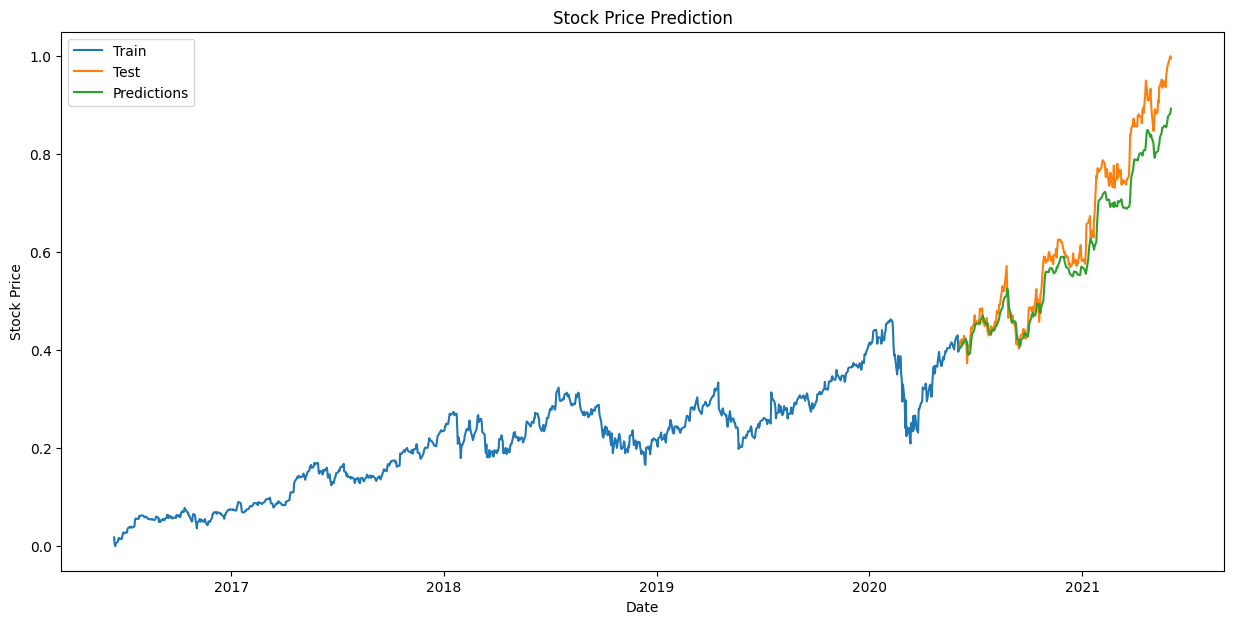

In [17]:
#setting up dates for plotting
dates_test = data.index[train_size:train_size + len(y_test_inverse)]
dates_train = data.index[:train_size]

#plot
plt.figure(figsize=(15, 7))
plt.plot(dates_train, y_train_inverse, label='Train')
plt.plot(dates_test, y_test_inverse, label='Test')
plt.plot(dates_test, y_pred_inverse, label='Predictions')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()